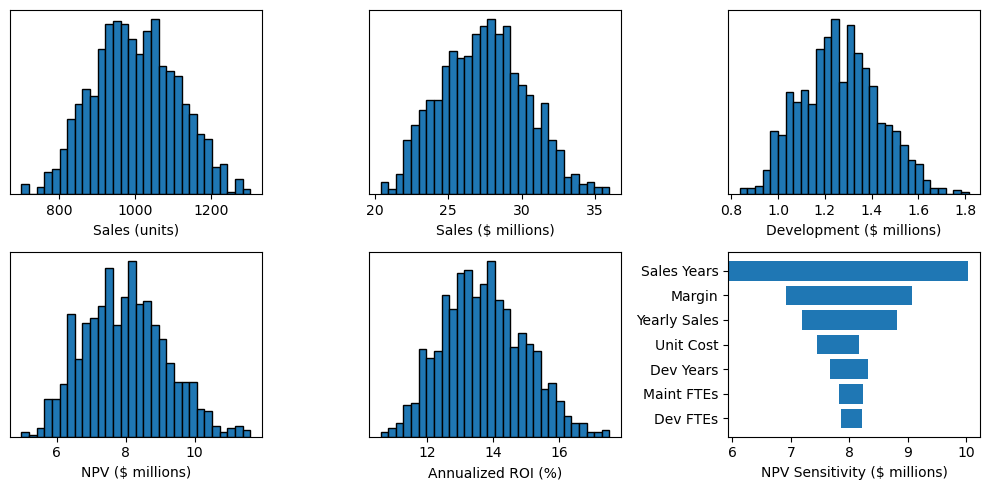

In [2]:
from enum import Enum
import numpy as np # linear algebra library
import matplotlib.pyplot as plt # plotting library

def pv(future_value, rate, periods):
    return future_value / (1 + rate) ** periods

def fv(present_value, rate, periods):
    return present_value * (1 + rate) ** periods

class CompanyConstants:
    def __init__(self):
        # what we would expect to earn on an investment in a financial market with a similar risk
        self.market_return = 0.03
        
        # how much it costs per person to run a product development team (in present dollars)
        self.yearly_development_fte_cost_pv = 50000
        
        # how much the cost of development increases each year
        self.development_cost_trend = 0.03
        
        # how much the cost of a product increases each year
        self.unit_cost_trend = 0.03
        
        # the percentage of the selling price that is allocated to cover selling, general, and administrative expenses
        self.sga_percentage = 0.30

class ProductVariablesRanges:
    def __init__(self):
        # development years profile
        self.years_before_development = 1.5
        self.years_of_development_growth = 0
        self.years_of_development_maturity = [3, 4, 5]
        self.years_of_development_decline = 0

        # sales years profile
        self.years_before_sales = 0
        self.years_of_sales_growth = 0
        self.years_of_sales_maturity = [8, 10, 12]
        self.years_of_sales_decline = 0
        
        # the number of people (full time equivalents) on the development team
        self.development_ftes = [4, 5, 6]

        # the number of people that need to keep working on the product after development
        self.maintenance_ftes = [0, 0.5, 1]
        
        # the cost to manufacture one unit of the product (in present dollars)
        self.unit_cost_pv = [8000, 10000, 12000]
        
        # the selling price cost factors to compute the price of the product (in present dollars)
        self.unit_price_cost_factor = [1.9, 2.0, 2.1]

        # the number of units that are expected to be sold per year
        self.yearly_unit_sales_lowest_price = [110, 120, 130]
        self.yearly_unit_sales_highest_price = [70, 80, 90]

    def lowest_price(self):
        return self.unit_cost_pv[0] * self.unit_price_cost_factor[0]
    
    def highest_price(self):
        return self.unit_cost_pv[2] * self.unit_price_cost_factor[2]

def triangle(a, tornado, key):
    if isinstance(a, list):
        if(tornado == Tornado.OFF or key == tornado):
            return np.random.triangular(a[0], a[1], a[2])
        else:
            return a[1]  
    else:   
        return a

class Tornado(Enum):
    OFF = 99
    Dev_Ftes = 0
    Dev_Years = 1
    Maint_Ftes = 2
    Sales_Years = 3
    Unit_Cost = 4
    Margin = 5
    Yearly_Sales = 6

class ProductVariablesSnapshot:
    def __init__(self, product_variables_ranges, tornado):
        
        # convert various ranges to actual value using a triangular distribution (or use the expected value if the tornado is on)
        self.development_ftes = triangle(product_variables_ranges.development_ftes, tornado, Tornado.Dev_Ftes)
        self.years_before_development = triangle(product_variables_ranges.years_before_development, tornado, Tornado.OFF)
        self.years_of_development_growth = triangle(product_variables_ranges.years_of_development_growth, tornado, Tornado.OFF)
        self.years_of_development_maturity = triangle(product_variables_ranges.years_of_development_maturity, tornado, Tornado.Dev_Years)
        self.years_of_development_decline = triangle(product_variables_ranges.years_of_development_decline, tornado, Tornado.OFF)
        self.maintenance_ftes = triangle(product_variables_ranges.maintenance_ftes, tornado, Tornado.Maint_Ftes)
        self.years_before_sales = triangle(product_variables_ranges.years_before_sales, tornado, Tornado.OFF)
        self.years_of_sales_growth = triangle(product_variables_ranges.years_of_sales_growth, tornado, Tornado.OFF)
        self.years_of_sales_maturity = triangle(product_variables_ranges.years_of_sales_maturity, tornado, Tornado.Sales_Years)
        self.years_of_sales_decline = triangle(product_variables_ranges.years_of_sales_decline, tornado, Tornado.OFF)
        self.unit_cost_pv = triangle(product_variables_ranges.unit_cost_pv, tornado, Tornado.Unit_Cost)
        self.unit_price_cost_factor = triangle(product_variables_ranges.unit_price_cost_factor, tornado, Tornado.Margin)

        # compute the unit price
        self.unit_price_pv = self.unit_cost_pv * self.unit_price_cost_factor

        # interpoloate the yearly unit sales range as a function of the unit price
        price_range = np.array([product_variables_ranges.lowest_price(), product_variables_ranges.highest_price()])
        yearly_unit_sales_range = [0, 0, 0]
        for i in range(3):
            sales_range_i = np.array([product_variables_ranges.yearly_unit_sales_lowest_price[i], product_variables_ranges.yearly_unit_sales_highest_price[i]])
            yearly_unit_sales_range[i] = np.interp(self.unit_price_pv, price_range, sales_range_i)
        
        # convert the sales range to actual value using a triangular distribution
        self.yearly_unit_sales = triangle(yearly_unit_sales_range, tornado, Tornado.Yearly_Sales)

        # precalculate the total remaining years
        self.total_remaining_years = self.years_before_development + self.years_of_development_growth + self.years_of_development_maturity + self.years_of_development_decline + self.years_before_sales + self.years_of_sales_growth + self.years_of_sales_maturity + self.years_of_sales_decline

    def development_ftes_this_month(self, month):
        if month < self.years_before_development * 12:
            return 0
        month -= self.years_before_development * 12
        if month < self.years_of_development_growth * 12:
            return self.development_ftes * month / (self.years_of_development_growth * 12)
        month -= self.years_of_development_growth * 12
        if month < self.years_of_development_maturity * 12:
            return self.development_ftes
        month -= self.years_of_development_maturity * 12
        if month < self.years_of_development_decline * 12:
            return self.development_ftes * (1 - month / (self.years_of_development_decline * 12))
        return self.maintenance_ftes
    
    def unit_sales_this_month(self, month):
        month -= self.years_before_development * 12
        month -= self.years_of_development_growth * 12
        month -= self.years_of_development_maturity * 12
        month -= self.years_of_development_decline * 12
        if month < self.years_before_sales * 12:
            return 0
        month -= self.years_before_sales * 12
        if month < self.years_of_sales_growth * 12:
            return self.yearly_unit_sales * month / (self.years_of_sales_growth * 12) / 12
        month -= self.years_of_sales_growth * 12
        if month < self.years_of_sales_maturity * 12:
            return self.yearly_unit_sales / 12
        month -= self.years_of_sales_maturity * 12
        if month < self.years_of_sales_decline * 12:
            return self.yearly_unit_sales * (1 - month / (self.years_of_sales_decline * 12)) / 12
        return 0

class NpvCalculationResult:
    def __init__(self):
        self.development_cost = 0
        self.sales = 0
        self.cost_of_goods = 0
        self.sga = 0
        self.unit_sales = 0
        self.total_remaining_years = 0

    def npv(self):
        return self.sales - self.cost_of_goods - self.sga - self.development_cost

    def roi(self):
        return self.npv() / self.development_cost

    def annualized_roi(self, years):
        return (1 + self.roi()) ** (1 / years) - 1

def calculate_npv(product_variables_snapshot, company_constants):

    # this is what we will calculate and return 
    result = NpvCalculationResult()

    # loop through all the months
    for month in range(round(product_variables_snapshot.years_before_development), round(product_variables_snapshot.total_remaining_years * 12)):
    
        # compute the development_ftes for this month
        development_ftes = product_variables_snapshot.development_ftes_this_month(month)

        # compute the unit sales for this month
        unit_sales = product_variables_snapshot.unit_sales_this_month(month)

        # compute the future value of the cost of development, unit cost, and unit price for this month
        monthly_development_cost_fte_fv = fv(company_constants.yearly_development_fte_cost_pv / 12, company_constants.development_cost_trend / 12, month)
        unit_cost_fv = fv(product_variables_snapshot.unit_cost_pv, company_constants.unit_cost_trend / 12, month)
        unit_price_fv = fv(product_variables_snapshot.unit_price_pv, company_constants.unit_cost_trend * product_variables_snapshot.unit_price_cost_factor / 12, month)

        # compute the selling, general, and administrative expenses per unit
        sga_fv = unit_price_fv * company_constants.sga_percentage

        # add the cost of development in present value terms
        result.development_cost += pv(development_ftes * monthly_development_cost_fte_fv, company_constants.market_return / 12, month)
        result.unit_sales += unit_sales
        result.sales += pv(unit_sales * unit_price_fv, company_constants.market_return / 12, month)
        result.cost_of_goods += pv(unit_sales * unit_cost_fv, company_constants.market_return / 12, month)
        result.sga += pv(unit_sales * sga_fv, company_constants.market_return / 12, month)

    # handy for the result
    result.total_remaining_years = product_variables_snapshot.total_remaining_years

    return result

class SimulationTracker:
    def __init__(self):
        self.npvs = []
        self.development_costs = []
        self.annualized_rois = []
        self.unit_sales = []
        self.sales = []
        self.years = []
    
    def add(self, result):
        self.npvs.append(result.npv() / 1000000)
        self.development_costs.append(result.development_cost / 1000000)
        self.annualized_rois.append(result.annualized_roi(result.total_remaining_years) * 100)
        self.unit_sales.append(result.unit_sales)
        self.sales.append(result.sales / 1000000)
        self.years.append(result.total_remaining_years)

class TornadoTracker:
    def __init__(self, tornado, name):
        self.tornado = tornado
        self.name = name
        self.min_value = float('inf')
        self.max_value = float('-inf')

    def add(self, value):
        if value < self.min_value:
            self.min_value = value
        if value > self.max_value:
            self.max_value = value
    
    def range(self):
        return self.max_value - self.min_value

class PpmMonteCarlo:
    def __init__(self):
        self.company_constants = CompanyConstants()
        self.product_variables_ranges = ProductVariablesRanges()
        self.simulation_tracker = SimulationTracker()
        self.tornado_trackers = []
        self.tornado_trackers.append(TornadoTracker(Tornado.Dev_Ftes, 'Dev FTEs'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Dev_Years, 'Dev Years'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Maint_Ftes, 'Maint FTEs'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Sales_Years, 'Sales Years'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Unit_Cost, 'Unit Cost'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Margin, 'Margin'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Yearly_Sales, 'Yearly Sales'))

    def analyze(self):
        # compute the monte carlo analysis
        for i in range(1000):
            product_variables_snapshot = ProductVariablesSnapshot(self.product_variables_ranges, Tornado.OFF)
            result = calculate_npv(product_variables_snapshot, self.company_constants)
            self.simulation_tracker.add(result)

        # compute the tornado analysis
        for i in range(100):    
            for tornado_tracker in self.tornado_trackers:
                product_variables_snapshot = ProductVariablesSnapshot(self.product_variables_ranges, tornado_tracker.tornado)
                result = calculate_npv(product_variables_snapshot, self.company_constants)
                tornado_tracker.add(result.npv() / 1000000)

        # Sort the tornado trackers by range
        self.tornado_trackers.sort(key=lambda x: x.range())
    
    # create a histogram
    def create_histogram(self, data, bins, xlabel, subplot_position, rows, cols):
        plt.subplot(rows, cols, subplot_position)
        plt.hist(data, bins=bins, edgecolor='black')
        plt.yticks([])
        plt.xlabel(xlabel)

    # create a tornado plot
    def create_tornado_plot(self, names, ranges, min_values, xlabel, subplot_position, rows, cols):
        plt.subplot(rows, cols, subplot_position)
        plt.barh(names, ranges, left=min_values)
        plt.xlabel(xlabel)

    def plot(self):
        rows = 2
        cols = 3
        plt.figure(figsize=(10, 5))

        self.create_histogram(self.simulation_tracker.unit_sales, 30, 'Sales (units)', 1, rows, cols)
        self.create_histogram(self.simulation_tracker.sales, 30, 'Sales ($ millions)', 2, rows, cols)
        self.create_histogram(self.simulation_tracker.development_costs, 30, 'Development ($ millions)', 3, rows, cols)
        self.create_histogram(self.simulation_tracker.npvs, 30, 'NPV ($ millions)', 4, rows, cols)
        self.create_histogram(self.simulation_tracker.annualized_rois, 30, 'Annualized ROI (%)', 5, rows, cols)
        # self.create_histogram(self.years, 30, 'Product Years', 6, rows, cols)

        tornado_names = [tornado_tracker.name for tornado_tracker in self.tornado_trackers]
        tornado_ranges = [tornado_tracker.range() for tornado_tracker in self.tornado_trackers]
        tornado_min_values = [tornado_tracker.min_value for tornado_tracker in self.tornado_trackers]
        self.create_tornado_plot(tornado_names, tornado_ranges, tornado_min_values, 'NPV Sensitivity ($ millions)', 6, rows, cols)

        plt.tight_layout()
        plt.show()

# Run the Monte Carlo simulation
monte_carlo = PpmMonteCarlo()
monte_carlo.analyze()
monte_carlo.plot()